In [1]:
!git clone https://github.com/LINKS-Foundation-CPE/Master-QCC-2022-2023.git

Cloning into 'Master-QCC-2022-2023'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 115 (delta 50), reused 99 (delta 39), pack-reused 0
Receiving objects: 100% (115/115), 293.44 KiB | 1.60 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [2]:
!pip install pulser==0.7
!pip install pybnb
!pip install networkx==2.8.7
!pip install matplotlib==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.3.3
    Uninstalling jsonschema-4.3.3:
      Successfully uninstalled jsonschema-4.3.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybnb: filename=pybnb-0.6.2-py2.py3-none-any.whl size=60618 sha256=1357882ebc2cffd9ccac5177ea05ec6d7dce5ff39ee6fca1a67b4a8676e803e3
  Stored in directory: /root/.cache/pip/wheels/e4/00/10/d3f482061807e286001f598b8e20139454a7482912996871e5
Successfully

In [3]:
%cd /content/Master-QCC-2022-2023/

/content/Master-QCC-2022-2023


In [4]:
%matplotlib inline

In [13]:
import numpy as np

import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser_simulation import SimConfig, Simulation
from pulser.waveforms import InterpolatedWaveform

from scipy.optimize import minimize, Bounds
from src.basic_MIS.utils import *
from scipy.spatial.distance import pdist, squareform

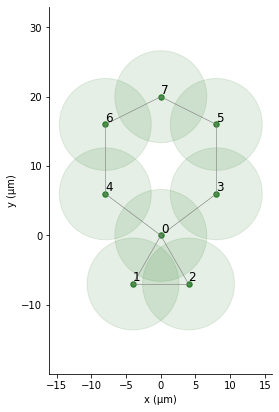

{'01011001', '00111001'}


In [6]:
# pos = np.array([[0., 0.], [-4, -7], [4,-7], [8,6], [-8,6]])
pos = np.array([[0., 0.], [-4, -7], [4,-7], [8,6], [-8,6], [8,16], [-8,16], [0,20]])
# pos = np.array([[0., 0.], [-4, -7], [4,-7], [8,6], [-8,6], [8,16], [-8,16], [0,20], [16,18], [-18,12]])

G = pos_to_graph(pos)
qubits = dict(enumerate(pos))

reg = Register(qubits)
reg.draw(blockade_radius=Chadoq2.rydberg_blockade_radius(1.), draw_graph=True, draw_half_radius=True ) #Assuming Rabi frequency = 1. rad/microsec

mis_ref = nx_mis(G)
print(mis_ref)

In [7]:
layers = 1
time_unit = 1000 # = 1 microsecond
detuning_amplitude = 1. # Must be between 0 and Rabi frequency, 1. is reasonable
guess = {'t': np.random.uniform(8, 10, layers),
         's': np.random.uniform(1, 3, layers)}

# Parametrized sequence
seq = Sequence(reg, Chadoq2)
seq.declare_channel('ch0','rydberg_global')

t_list = seq.declare_variable('t_list', size=layers)
s_list = seq.declare_variable('s_list', size=layers)

if layers == 1:
    t_list = [t_list]
    s_list = [s_list]

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(time_unit*t, 1., 0., 0)
    pulse_2 = Pulse.ConstantPulse(time_unit*s, 1., detuning_amplitude, 0)

    seq.add(pulse_1, 'ch0')
    seq.add(pulse_2, 'ch0')

# Bounds for max total pulse length (machine max = 100, reasonable values < 20)
max_time = 10.
step_time = max_time/layers
lb = []
ub = []
for t in t_list:
    lb.append(0.016) # minimum length of laser pulse
    ub.append(step_time*0.7)
for s in s_list:
    lb.append(0.016)
    ub.append(step_time*0.3)
np_ub = np.array(ub)
np_lb = np.array(lb)

In [37]:
# We choose a median value between the min and the max
distances = pdist(pos)
Q = Chadoq2.interaction_coeff / pdist(pos) ** 6
print(Q)
Omega = np.average(Q)
print(Omega)
# Omega = 5
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

[1.97365809e+01 1.97365809e+01 5.42015853e+00 5.42015853e+00
 1.65410111e-01 1.65410111e-01 8.46899770e-02 2.06762639e+01
 1.76757958e-01 8.56045412e-01 1.77814346e-02 3.34828550e-02
 1.31082034e-02 8.56045412e-01 1.76757958e-01 3.34828550e-02
 1.77814346e-02 1.31082034e-02 3.23066624e-01 5.42015853e+00
 1.20132909e-01 3.08384077e-01 1.20132909e-01 5.42015853e+00
 3.08384077e-01 3.23066624e-01 1.05862471e+01 1.05862471e+01]
3.825556544618698


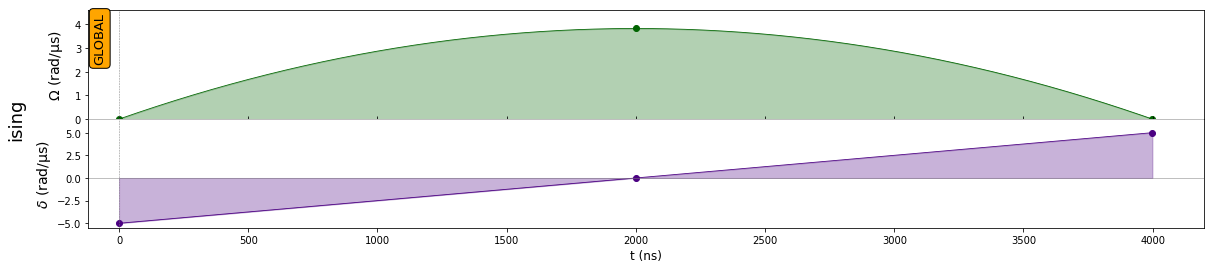

In [38]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [39]:
simul = Simulation(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

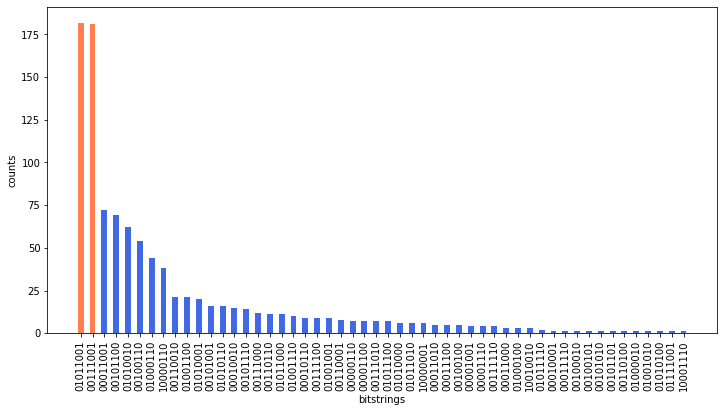

In [40]:
plot_distribution(count_dict, mis_ref)

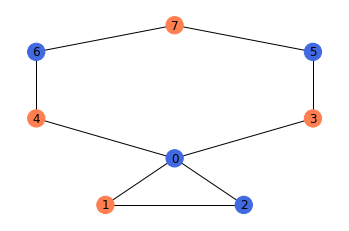

In [41]:
cmap = ['royalblue','coral']
clist = [cmap[int(c)] for c in get_mis_string(count_dict)]
f = plt.figure()
nx.draw(G, pos=pos, node_color=clist, with_labels=True, ax=f.add_subplot(111))